# Introduction

This first notebook allows to download all necessary data and metadata for the tutorial. This allows the user to get ready with their own data in order to later use the tutorial to analyze their own data.

Note that this tutorial uses `Path` objects to handle file paths. This is a very convenient way to handle file paths in Python. If you are not familiar with `Path` objects, you can read the [official `pathlib` documentation](https://docs.python.org/3/library/pathlib.html). Also note that the velocity model is stored as a `h5` file, which is a binary file format but not mandatory and implies the use of the `h5py` library. If you are not familiar with `h5` files, you can read the [h5py documentation](https://docs.h5py.org/en/stable/).

In [1]:
from pathlib import Path

import h5py as h5
import numpy as np
import obspy

import covseisnet as csn

## Download the seimograms

This first cell downloads the continuous seismograms from the RESIF datacenter. The dataset is about 60MB. The function is written under the `covseisnet.data` module, and internally calls the `covseisnet.data.download_seismic_dataset` function. Please have a look at its documentation for more information.

In [2]:
# Set the download path for the data
filepath = Path("data/undervolc.mseed")
filepath.parent.mkdir(exist_ok=True)

# Download the data
csn.data.download_undervolc_data(filepath_destination=filepath)

# Check stream
stream = csn.read(filepath)

Data saved to data/undervolc.mseed


## Download data inventory

Most notebooks will make use of useful metadata accessible in the inventory of the RESIF datacenter. This inventory is a XML file that can be obtained with obspy. The inventory is here downloaded with a special method from `covseisnet.NetworkStream` called `download_inventory`. The file is then written aside the seismograms in the `data` directory.

In [3]:
# Download the inventory
inventory = stream.download_inventory(datacenter="RESIF")

# Write the inventory to a file
inventory.write("data/undervolc.xml", "stationxml")

The `inventory` object is an ObsPy object that comes with several useful methods such as a plotting one. If `cartopy` is installed, the inventory can be plotted on a map as in the following example.

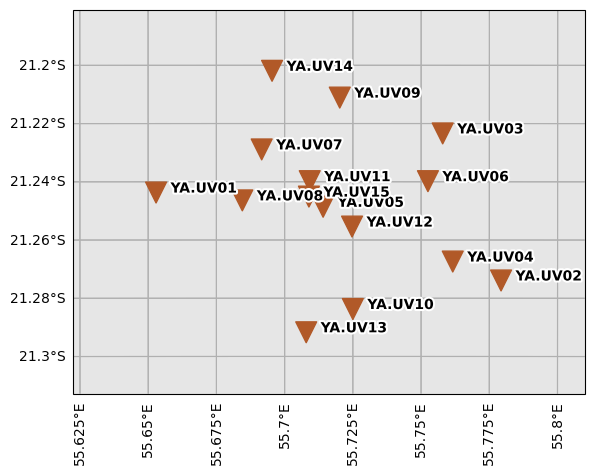

In [4]:
# Read the inventory
inventory = obspy.read_inventory("data/undervolc.xml")

# Plot the inventory
fig = inventory.plot(projection="local", show=False)

# Extract axes for custom labelling
ax = fig.axes[0]
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.right_labels = False

## Read the velocity model of the Piton de la Fournaise volcano

We use the 3D velocity model of the Piton de la Fournaise volcano (Morder et al. 2014), accessible in the supplementary material. We first turn the grid into a `h5` file and read it here before filling a regular 3D grid. The model can be displyaed with the `grid3d` function of the `covseisnet.plot` function. 

> Mordret, A., Rivet, D., Landès, M., & Shapiro, N. M. (2015). Three‐dimensional shear velocity anisotropic model of Piton de la Fournaise Volcano (La Réunion Island) from ambient seismic noise. Journal of Geophysical Research: Solid Earth, 120(1), 406-427.

{'xy': <Axes: label='xy', ylabel='Latitude (º)'>,
 'zy': <Axes: label='zy', xlabel='Depth (km)'>,
 'xz': <Axes: label='xz', xlabel='Longitude (º)', ylabel='Depth (km)'>,
 'cb': <Axes: label='cb', xlabel='$V_s$ (km/s)'>}

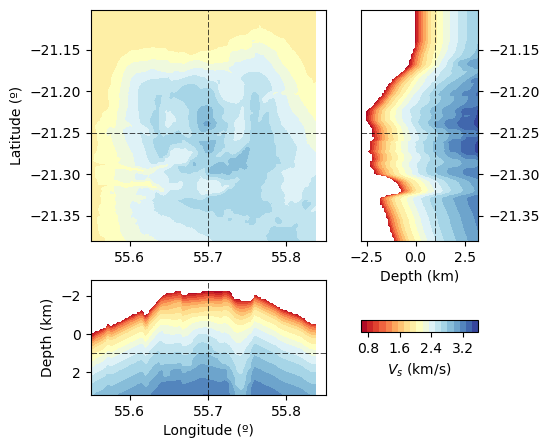

In [15]:
# Read the model
filepath_model = Path("data/velocity_model_Mordret2025.h5").absolute()
velocity_field_name = "Vs"

# The h5 file contains the velocity model in a 3D grid with the following
# dimensions in order: longitude, latitude, depth. The depth and velocity are
# in meters and meters per second, respectively.
with h5.File(filepath_model, "r") as velocity_model:

    # Coordinates
    lon = np.array(velocity_model["longitude"])
    lat = np.array(velocity_model["latitude"])
    depth = np.array(velocity_model["depth"]) * 1e-3

    # Velocity
    velocity = np.array(velocity_model[velocity_field_name])
    velocity /= 1e3

# Get extent
model = csn.velocity.model_from_grid(lon, lat, depth, velocity)

# Plot the grid
csn.plot.grid3d(model, profile_coordinates=[55.7, -21.25, 1], cmap="RdYlBu", label="$V_s$ (km/s)")

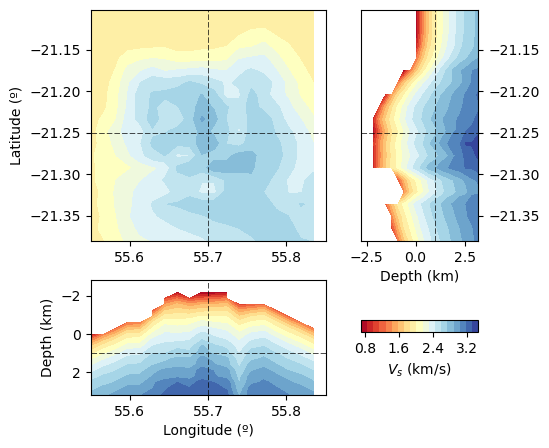

In [31]:
model_i = model.resample((20, 20, 20))

csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)

csn.plot.plt.show()

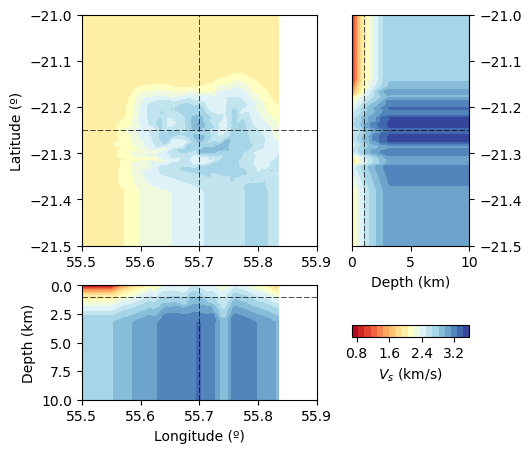

In [45]:
lons = np.linspace(55.5, 55.9, 100)
lats = np.linspace(-21.5, -21, 100)
depths = np.linspace(0, 10, 100)

model_i = model.interpolate(lons, lats, depths)

csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)
csn.plot.plt.show()

In [44]:
model_i.lon

array([55.5       , 55.5040404 , 55.50808081, 55.51212121, 55.51616162,
       55.52020202, 55.52424242, 55.52828283, 55.53232323, 55.53636364,
       55.54040404, 55.54444444, 55.54848485, 55.55252525, 55.55656566,
       55.56060606, 55.56464646, 55.56868687, 55.57272727, 55.57676768,
       55.58080808, 55.58484848, 55.58888889, 55.59292929, 55.5969697 ,
       55.6010101 , 55.60505051, 55.60909091, 55.61313131, 55.61717172,
       55.62121212, 55.62525253, 55.62929293, 55.63333333, 55.63737374,
       55.64141414, 55.64545455, 55.64949495, 55.65353535, 55.65757576,
       55.66161616, 55.66565657, 55.66969697, 55.67373737, 55.67777778,
       55.68181818, 55.68585859, 55.68989899, 55.69393939, 55.6979798 ,
       55.7020202 , 55.70606061, 55.71010101, 55.71414141, 55.71818182,
       55.72222222, 55.72626263, 55.73030303, 55.73434343, 55.73838384,
       55.74242424, 55.74646465, 55.75050505, 55.75454545, 55.75858586,
       55.76262626, 55.76666667, 55.77070707, 55.77474747, 55.77